In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import time
import os

rnd = 384
np.random.seed(rnd)

In [2]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/adult_clear.csv')
df = df[df["workclass"] != "?"]
df = df[df["occupation"] != "?"]
df = df[df["native-country"] != "?"]
df.replace(['Divorced', 'Married-AF-spouse',
            'Married-civ-spouse', 'Married-spouse-absent',
            'Never-married', 'Separated', 'Widowed'],
           ['notmarried', 'married', 'married', 'married',
            'notmarried', 'notmarried', 'notmarried'], inplace=True)
df['education'].replace(['Preschool', '10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th'], 'dropout',
                        inplace=True)
df['education'].replace(['HS-Grad', 'HS-grad'], 'HighGrad', inplace=True)
df['education'].replace(['Some-college', 'Assoc-acdm', 'Assoc-voc'], 'CommunityCollege', inplace=True)
df = df[df.race == 'White']
# excludes 10 observations
df = df[df['workclass'] != 'Never-worked']
# excludes 14 observations
df = df[df['occupation'] != 'Armed-Forces']
# excludes 21 observations
df = df[df['workclass'] != 'Without-pay']
df.drop(['fnlwgt', 'educational-num', 'relationship', 'race', 'capital-gain', 'capital-loss'],
            axis=1, inplace=True)
df['workclass'].replace(['Local-gov', 'State-gov', 'Federal-gov'], 'Gov', inplace=True)
df['workclass'].replace(['Private', 'Self-emp-not-inc', 'Self-emp-inc'], 'Private', inplace=True)
df['occupation'].replace(
    ['Craft-repair', 'Machine-op-inspct', 'Handlers-cleaners', 'Transport-moving', 'Adm-clerical',
     'Farming-fishing'], 'BlueCollar', inplace=True)
df['occupation'].replace(['Other-service', 'Protective-serv', 'Tech-support', 'Priv-house-serv'], 'Services',
                         inplace=True)
df['occupation'].replace(['Exec-managerial'], 'ExecManagerial', inplace=True)
df['occupation'].replace(['Prof-specialty'], 'ProfSpecialty', inplace=True)
df['education'].replace(['Prof-school'], 'ProfSchool', inplace=True)
df['native-country'].replace(['Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', \
                              'El-Salvador', 'England', 'France', 'Germany', 'Greece', 'Guatemala', 'Haiti',\
                              'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary', 'India', 'Iran', 'Ireland',\
                              'Italy', 'Jamaica', 'Japan', 'Mexico', 'Nicaragua', 'Outlying-US(Guam-USVI-etc)',\
                              'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto-Rico', 'Scotland', 'South',\
                              'Taiwan','Thailand', 'Trinadad&Tobago', 'Vietnam','Yugoslavia'], 'Non_US', inplace=True)
df.rename(columns={'hours-per-week': 'hoursPerWeek'}, inplace=True)
df.rename(columns={'marital-status': 'marital_status'}, inplace=True)
df.rename(columns={'native-country': 'native_country'}, inplace=True)
columns_titles = ["age","hoursPerWeek","education","marital_status","occupation","gender","native_country","income"]
df=df.reindex(columns=columns_titles)
df = df[~df.duplicated()]
X = df.copy()
enc = OrdinalEncoder()
std = MinMaxScaler(feature_range=(-1,1))
X.iloc[:,2:] = enc.fit_transform(X.values[:,2:]).astype(int)
X.iloc[:,:2] = std.fit_transform(X.values[:,:2])
X.drop(['income'], axis=1, inplace=True)
y = df["income"].apply(lambda x: ">50K" in x).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rnd)

In [3]:
X_train

,age,hoursPerWeek,education,marital_status,occupation,gender,native_country
17534,-0.041096,-0.142857,3,1,0,0,1
14204,-0.342466,-0.040816,3,1,0,1,1
18447,-0.178082,-0.204082,3,0,3,1,1
10398,0.013699,-0.204082,1,1,3,0,1
24516,-0.753425,-0.367347,6,1,2,0,1
...,...,...,...,...,...,...,...
35701,-0.150685,-0.714286,3,1,2,1,1
11005,-0.671233,-0.204082,6,1,0,0,1
952,-0.369863,-0.204082,3,0,0,0,1
47357,-0.095890,0.102041,4,0,3,1,1


In [4]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train.values, y_train.values)
# train model
bst = xgb.train({'objective':'binary:logistic'}, dtrain, 20)
bst.save_model('black_box.bst')

[11:14:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/francescobodria/anaconda3/envs/latent_space/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
def predict(x):
    if len(x.shape)==1:
        d = xgb.DMatrix(x.reshape(1,-1))
    else:
        d = xgb.DMatrix(x)
    return bst.predict(d)

In [6]:
dtest = xgb.DMatrix(X_test.values)
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

train acc: 0.7878918254456054
test acc: 0.7647492625368731


In [7]:
X_train = np.hstack((X_train.values,y_train_pred.reshape(-1,1)))
X_test = np.hstack((X_test.values,y_test_pred.reshape(-1,1)))

In [22]:
latent_dim = 2 
batch_size = 4096
sigma = 3
max_epochs = 2000
early_stopping = 3
learning_rate = 1e-3

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')
    
def compute_similarity(X,sigma=1):
    M = torch.exp((-torch.cdist(X,X)**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)
    
def similarity_loss_function(X, Z, sigma=1):
    Sx = compute_similarity(X, sigma)
    Sz = compute_similarity(Z, 1)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

def distribution_loss_function(Z):
    return (torch.std(Z)**2 + torch.mean(Z)**2 - torch.log(torch.std(Z)) - 1/2).sum()

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim=2):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z

# Create Model
model = LinearModel(X_train.shape[1], latent_dim=latent_dim)

In [23]:
train_dataset = TensorDataset(torch.tensor(X_train).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
            postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []

    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  #
        sim_loss  = similarity_loss_function(X_batch, Z_batch, sigma)
        dis_loss  = distribution_loss_function(Z_batch)  
        loss = sim_loss + dis_loss
        loss.backward()
        optimizer.step()
        batch_loss.append([loss.item(),sim_loss.item(),dis_loss.item()])

    # save result
    epoch_train_losses.append(np.mean(batch_loss, axis=0))
    pbar.postfix[3]["value"] = epoch_train_losses[-1][0]

    # -------- VALIDATION --------

    # set model as testing mode
    model.eval()
    batch_loss = []

    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            sim_loss  = similarity_loss_function(X_batch, Z_batch, sigma)
            dis_loss  = distribution_loss_function(Z_batch)  
            loss = sim_loss + dis_loss
            batch_loss.append([loss.item(),sim_loss.item(),dis_loss.item()])

    # save information
    epoch_test_losses.append(np.mean(batch_loss, axis=0))
    pbar.postfix[5]["value"] = epoch_test_losses[-1][0]
    pbar.postfix[1]["value"] = epoch

    if epoch_test_losses[-1][0] < best:
        wait = 0
        best = epoch_test_losses[-1][0]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/adult_KLD_{latent_dim}.pt')

Epoch: 000 Train Sim Loss 0.00000 Test Sim Loss 0.00000 Early Stopping 0

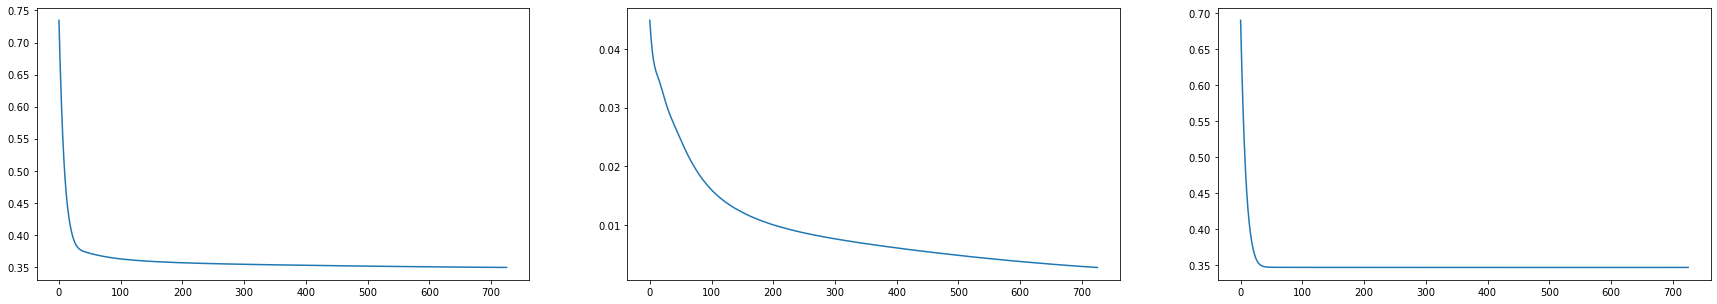

In [24]:
epoch_test_losses = np.stack(epoch_test_losses)
epoch_train_losses = np.stack(epoch_train_losses)
F, ax = plt.subplots(1,3,figsize=(30,5))
ax[0].plot(epoch_test_losses[:,0])
ax[1].plot(epoch_test_losses[:,1])
ax[2].plot(epoch_test_losses[:,2])

In [25]:
model.load_state_dict(torch.load(f'./models/adult_KLD_{latent_dim}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

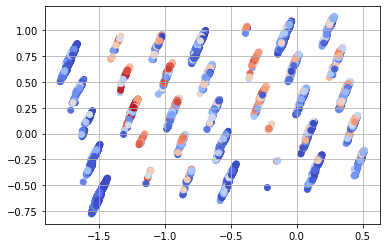

In [26]:
plt.scatter(Z_train[:,0],Z_train[:,1],c=y_train_pred,cmap='coolwarm')
plt.grid()

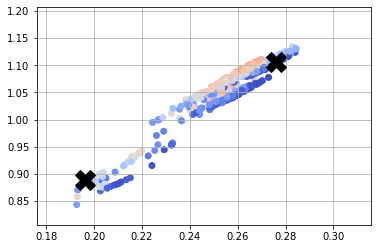

In [52]:
y_contrib = model.fc1.weight.detach().numpy()[:,-1]
plt.scatter(Z_train[:,0], Z_train[:,1], c=y_train_pred, cmap='coolwarm')
plt.plot(Z_test[idx,0], Z_test[idx,1], 'kX', markersize=20)
m = -1
plt.plot(Z_test[idx,0]+m*y_contrib[0], Z_test[idx,1]+m*y_contrib[1], 'kX', markersize=20)
plt.axis([Z_test[idx,0]-0.1,Z_test[idx,0]+0.04,Z_test[idx,1]-0.3,Z_test[idx,1]+0.1])
plt.grid()